# **Analysis of Voter Abstention on Brazil's Presidential Elections through Data Clustering**

Dataset link:
https://drive.google.com/file/d/10mr3g08njJv1jVCTdFjNkNO5s51Iqvyv/view?usp=sharing


In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
# I chose to upload the dataset to Google Drive and work with Colab
# If you wont be using Colab, delete this cell and adjust the path on the next one

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/My Drive/justificativa.csv', sep=';')

In [5]:
# Irrelevant for the analysis
df = df.drop(columns=['Data de carga', 'Município', 'País', 'Turno'])

In [6]:
# Columns dropped due to high amount of missing data
df = df.drop(columns=['Raça / cor', 'Identidade de gênero'])

In [7]:
df['UF!=UFjus'] = (df['UF'] != df['UF justificativa']).astype(int)

df = df.drop(columns = ['UF', 'UF justificativa'])

In [8]:
df['Intérprete de libras'] = df['Intérprete de libras'].replace(['N�O INFORMADO', 'N�O'], ['NAO INFORMADO', 'NAO'])
df['Quilombola'] = df['Quilombola'].replace(['N�O INFORMADO', 'N�O'], ['NAO INFORMADO', 'NAO'])
df['Obrigatoriedade do voto'] = df['Obrigatoriedade do voto'].replace('Obrigat�rio', 'Obrigatorio')
df['Grau de instrução'] = df['Grau de instrução'].replace(['L� E ESCREVE', 'ENSINO M�DIO COMPLETO', 'ENSINO M�DIO INCOMPLETO', 'N�O INFORMADO'],
 ['LE E ESCREVE', 'ENSINO MEDIO COMPLETO', 'ENSINO MEDIO INCOMPLETO', 'NAO INFORMADO'])
df['Faixa etária'] = df['Faixa etária'].replace('Inv�lida', 'Invalida')
df['Estado civil'] = df['Estado civil'].replace(['N�O INFORMADO', 'VI�VO'], ['NAO INFORMADO', 'VIUVO'])
df['Gênero'] = df['Gênero'].replace('N�O INFORMADO', 'NAO INFORMADO')

In [9]:
df.head(5)

,Estado civil,Faixa etária,Intérprete de libras,Quilombola,Região,Ano de eleição,Gênero,Grau de instrução,Nome social,Obrigatoriedade do voto,Situação do eleitor,Quantidade de justificativas,UF!=UFjus
0,CASADO,100 anos ou mais,NAO INFORMADO,NAO INFORMADO,CENTRO-OESTE,2024,MASCULINO,ANALFABETO,N,Facultativo,Apto,1,1
1,CASADO,100 anos ou mais,NAO INFORMADO,NAO INFORMADO,NORDESTE,2024,FEMININO,ENSINO FUNDAMENTAL INCOMPLETO,N,Facultativo,Inapto,1,1
2,CASADO,100 anos ou mais,NAO INFORMADO,NAO INFORMADO,SUDESTE,2024,MASCULINO,LE E ESCREVE,N,Facultativo,Inapto,1,1
3,CASADO,100 anos ou mais,NAO INFORMADO,NAO INFORMADO,SUDESTE,2024,MASCULINO,LE E ESCREVE,N,Facultativo,Apto,1,1
4,CASADO,100 anos ou mais,NAO INFORMADO,NAO INFORMADO,SUDESTE,2024,FEMININO,LE E ESCREVE,N,Facultativo,Inapto,1,1


In [10]:
# Treating binary/ternary variables
df['Nome social'] = df['Nome social'].map({'S': 1, 'N': 0})
df['Intérprete de libras'] = df['Intérprete de libras'].map({'SIM': 1, 'NAO': 0, 'NAO INFORMADO': -1})
df['Quilombola'] = df['Quilombola'].map({'SIM': 1, 'NAO': 0, 'NAO INFORMADO': -1})
df['Obrigatoriedade do voto'] = df['Obrigatoriedade do voto'].map({
    'Obrigatorio': 1, 'Facultativo': 0
})
df['Situação do eleitor'] = df['Situação do eleitor'].map({'Apto': 1, 'Inapto': 0})

In [54]:
unique_voting_values = df['Quantidade de justificativas'].unique()
len(unique_voting_values)

1193

In [11]:
df.head(5)

,Estado civil,Faixa etária,Intérprete de libras,Quilombola,Região,Ano de eleição,Gênero,Grau de instrução,Nome social,Obrigatoriedade do voto,Situação do eleitor,Quantidade de justificativas,UF!=UFjus
0,CASADO,100 anos ou mais,-1,-1,CENTRO-OESTE,2024,MASCULINO,ANALFABETO,0,0,1,1,1
1,CASADO,100 anos ou mais,-1,-1,NORDESTE,2024,FEMININO,ENSINO FUNDAMENTAL INCOMPLETO,0,0,0,1,1
2,CASADO,100 anos ou mais,-1,-1,SUDESTE,2024,MASCULINO,LE E ESCREVE,0,0,0,1,1
3,CASADO,100 anos ou mais,-1,-1,SUDESTE,2024,MASCULINO,LE E ESCREVE,0,0,1,1,1
4,CASADO,100 anos ou mais,-1,-1,SUDESTE,2024,FEMININO,LE E ESCREVE,0,0,0,1,1


In [12]:
# Age and Education are ordinal, so they must be treated differently
ordinal_cols = ['Faixa etária', 'Grau de instrução']

faixa_etaria_order = [
    '16 anos', '17 anos', '18 anos', '19 anos', '20 anos',
    '21 a 24 anos', '25 a 29 anos', '30 a 34 anos', '35 a 39 anos',
    '40 a 44 anos', '45 a 49 anos', '50 a 54 anos', '55 a 59 anos',
    '60 a 64 anos', '65 a 69 anos', '70 a 74 anos', '75 a 79 anos',
    '80 a 84 anos', '85 a 89 anos', '90 a 94 anos', '95 a 99 anos',
    '100 anos ou mais', 'Invalida'
]

instrucao_order = ['NAO INFORMADO',
                   'ANALFABETO', 'LE E ESCREVE',
                   'ENSINO FUNDAMENTAL INCOMPLETO', 'ENSINO FUNDAMENTAL COMPLETO',
                   'ENSINO MEDIO INCOMPLETO', 'ENSINO MEDIO COMPLETO',
                   'SUPERIOR INCOMPLETO', 'SUPERIOR COMPLETO']

ord_encoder = OrdinalEncoder(categories=[faixa_etaria_order, instrucao_order])

In [13]:
# These columns have multiple values which must me treated, so I chose to use
# one-hot encoding
onehot_cols = ['Estado civil', 'Região', 'Gênero']

onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [14]:
numeric_cols = ['Ano de eleição', 'Quantidade de justificativas']

In [15]:
# Applies all of the pre-processing steps that were set up
# Impossible to use Gower distance with sklearn
preprocessor = ColumnTransformer(transformers=[
    ('ord', ord_encoder, ordinal_cols),
    ('onehot', onehot_encoder, onehot_cols),
    ('num', StandardScaler(), numeric_cols)
], remainder='passthrough')

=== Elbow Method ===
k=1, Inertia=40562187.73
k=2, Inertia=24148746.70
k=3, Inertia=19815056.78
k=4, Inertia=16992055.09
k=5, Inertia=14628608.25
k=6, Inertia=13674445.04
k=7, Inertia=12333360.05
k=8, Inertia=11814603.62
k=9, Inertia=11045067.83
k=10, Inertia=10543442.01
k=11, Inertia=10019743.94
k=12, Inertia=9746688.06
k=13, Inertia=9442832.03
k=14, Inertia=8909239.95
k=15, Inertia=8710762.68


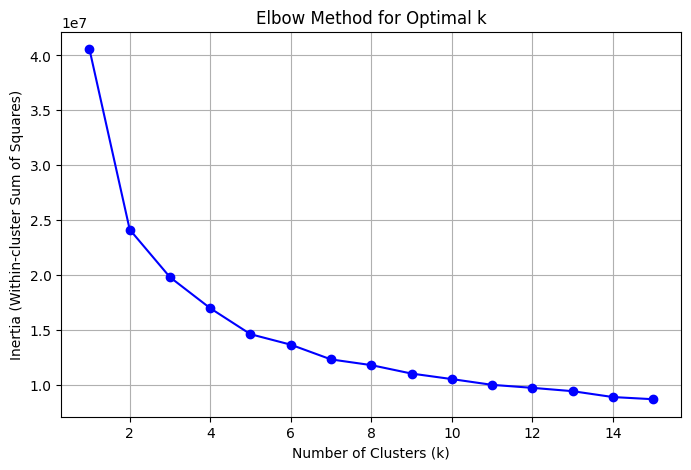

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Preprocess your data once
X_processed = preprocessor.fit_transform(df)

# Elbow Method setup
inertias = []
k_values = range(1, 16)  # k from 1 to 15

print("=== Elbow Method ===")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_processed)
    inertias.append(kmeans.inertia_)
    print(f"k={k}, Inertia={kmeans.inertia_:.2f}")

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [16]:
k_chosen = 12


In [ ]:
# Takes around 15 minutes to run
print(f"\n=== Silhouette Score for k={k_chosen} ===")
kmeans = KMeans(n_clusters=k_chosen, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_processed)
score = silhouette_score(X_processed, labels)
print(f"Silhouette Score (k={k_chosen}): {score:.4f}")

In [17]:
# Applies K-Means

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('clustering', KMeans(n_clusters=k_chosen, random_state=42))
])

pipeline.fit(df)
clusters = pipeline.named_steps['clustering'].labels_

In [19]:
pd.options.display.max_columns = 0

df['Cluster'] = clusters

from mlxtend.preprocessing import TransactionEncoder

# Convert rows into list of strings like 'gender=Male', 'age=60-69'
transactions = []
for _, row in df.iterrows():
    row_items = []
    row_items.append(f"gender={row['Gênero']}")
    row_items.append(f"age_group={row['Faixa etária']}")
    row_items.append(f"schooling={row['Grau de instrução']}")
    row_items.append(f"cluster={row['Cluster']}")
    # Addying more rows is great and could lead to better analysis, but running
    # on Colab would lead to GPU overflow
    transactions.append(row_items)

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)


In [20]:
from mlxtend.frequent_patterns import apriori, association_rules

# Find frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

# Extract rules
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.6)

In [21]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(age_group=18 anos),(cluster=5),0.013281,0.055732,0.013281,1.000000,17.943017,1.0,0.012541,inf,0.956978,0.238300,1.000000,0.619150
1,(age_group=19 anos),(cluster=5),0.019397,0.055732,0.019397,1.000000,17.943017,1.0,0.018316,inf,0.962946,0.348039,1.000000,0.674020
2,(age_group=20 anos),(cluster=5),0.021751,0.055732,0.019609,0.901506,16.175732,1.0,0.018396,9.587034,0.959039,0.338815,0.895692,0.626672
3,(age_group=21 a 24 anos),(cluster=1),0.060684,0.125968,0.050546,0.832938,6.612277,1.0,0.042902,5.231770,0.903600,0.371371,0.808860,0.617099
4,(age_group=25 a 29 anos),(cluster=1),0.096252,0.125968,0.073362,0.762183,6.050591,1.0,0.061237,3.675230,0.923628,0.492828,0.727908,0.672282
5,(cluster=4),(age_group=65 a 69 anos),0.050042,0.058357,0.032468,0.648818,11.118160,1.0,0.029548,2.681353,0.957997,0.427604,0.627054,0.602597
6,"(gender=FEMININO, age_group=19 anos)",(cluster=5),0.010159,0.055732,0.010159,1.000000,17.943017,1.0,0.009593,inf,0.953960,0.182289,1.000000,0.591145
7,"(age_group=20 anos, gender=FEMININO)",(cluster=5),0.011290,0.055732,0.010036,0.888909,15.949711,1.0,0.009407,8.499957,0.948006,0.176110,0.882352,0.534491
8,"(gender=FEMININO, age_group=21 a 24 anos)",(cluster=1),0.031521,0.125968,0.027038,0.857803,6.809671,1.0,0.023068,6.146633,0.880917,0.207269,0.837309,0.536224
9,"(age_group=21 a 24 anos, gender=MASCULINO)",(cluster=1),0.029164,0.125968,0.023508,0.806063,6.398928,1.0,0.019834,4.506771,0.869069,0.178596,0.778112,0.496339


In [37]:
print("=== MÉDIAS DE ABSTENÇÕES POR CLUSTER ===")
print(df.groupby('Cluster')[['Quantidade de justificativas']].mean())

=== MÉDIAS DE ABSTENÇÕES POR CLUSTER ===
         Quantidade de justificativas
Cluster                              
0                            3.941375
1                            5.706941
2                            3.347605
3                            4.002786
4                            1.721137
5                            2.061232
6                         2907.751244
7                            1.978726
8                            2.178079
9                            2.277346
10                           5.308335
11                           2.732558


In [40]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Optional: show all columns
pd.set_option('display.width', None)  # Don't break lines to fit the screen
pd.set_option('display.max_colwidth', None)  # Show full column contents (if you have long strings)

In [41]:
categorical_cols = ['Faixa etária', 'Grau de instrução', 'Estado civil',
                    'Região', 'Gênero', 'UF!=UFjus']

for col in categorical_cols:
    print(f"\n=== DISTRIBUIÇÃO DE '{col}' POR CLUSTER ===")
    print(df.groupby('Cluster')[col].value_counts(normalize=True).rename("Proporção").mul(100).round(1))



=== DISTRIBUIÇÃO DE 'Faixa etária' POR CLUSTER ===
Cluster  Faixa etária    
0        55 a 59 anos        27.6
         60 a 64 anos        25.6
         50 a 54 anos        22.6
         65 a 69 anos        15.8
         70 a 74 anos         5.8
         75 a 79 anos         2.1
         80 a 84 anos         0.6
1        25 a 29 anos        58.2
         21 a 24 anos        40.1
         20 anos              1.6
         30 a 34 anos         0.0
2        45 a 49 anos        55.9
         50 a 54 anos        44.1
         55 a 59 anos         0.0
3        30 a 34 anos        39.5
         35 a 39 anos        32.3
         40 a 44 anos        28.2
4        65 a 69 anos        64.9
         70 a 74 anos        23.4
         75 a 79 anos         7.9
         80 a 84 anos         2.6
         85 a 89 anos         0.9
         90 a 94 anos         0.2
         95 a 99 anos         0.1
         100 anos ou mais     0.0
         Invalida             0.0
5        20 anos             35.2
    

Como analisar os clusters? Regras de associação e estatística

Transformar abstenções em String